# Progress report 2022-06-27
Daniel Mishler

- 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import parsec_animation_utils as panimate

In [3]:
from matplotlib.animation import FuncAnimation
from IPython import display
plt.ioff()

## Tilesize investigation

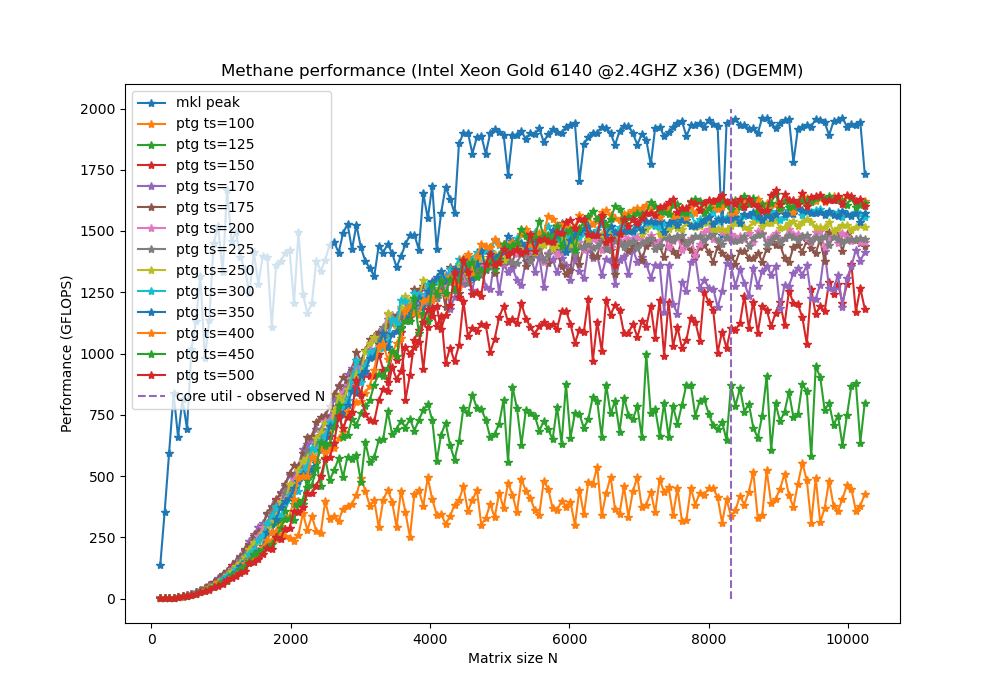

In [32]:
dgemm_methane_peak_stable = pd.read_csv("2022-06-14_36_core_peak_test.csv")
plt.ioff()
tilesizes = [100, 125, 150, 170, 175, 200, 225, 250, 300, 350, 400, 450, 500]
dgemm_methane_ptg = {}

plt.figure(figsize = [10,7])
for tilesize in tilesizes:
    dgemm_methane_ptg[tilesize] = pd.read_csv("2022-06-21_ptg_ts%d_dgemm.csv"% tilesize)

plt.plot(dgemm_methane_peak_stable["N"],    dgemm_methane_peak_stable["GFLOPS"],    "*-", label = "mkl peak")
for tilesize in tilesizes:
    plt.plot(dgemm_methane_ptg[tilesize]["N"],
             dgemm_methane_ptg[tilesize]["GFLOPS"],
             "*-", label = "ptg ts=%d" % tilesize)
plt.plot([8320,8320], [0,2000], "--", label="core util - observed N")


plt.title("Methane performance (Intel Xeon Gold 6140 @2.4GHZ x36) (DGEMM)")
plt.legend()
plt.xlabel("Matrix size N")
plt.ylabel("Performance (GFLOPS)")
fname = '2022-06-21_methane_trace_performance_investigation'
plt.savefig(fname + '.svg')
plt.savefig(fname + '.pdf')
plt.savefig(fname + '.png')
display.Image(fname+'.png')

In [33]:
dgemm_mkl_peak = max(dgemm_methane_peak_stable["GFLOPS"])
tilesizemax = []
for tilesize in tilesizes:
    tilesizemax.append(max(dgemm_methane_ptg[tilesize]["GFLOPS"]))
dgemm_dplasma_peak = max(tilesizemax)
peak_utilization = dgemm_dplasma_peak/dgemm_mkl_peak
print("We do about %f%s as well as mkl" % (peak_utilization*100, "%"))

We do about 85.007368% as well as mkl


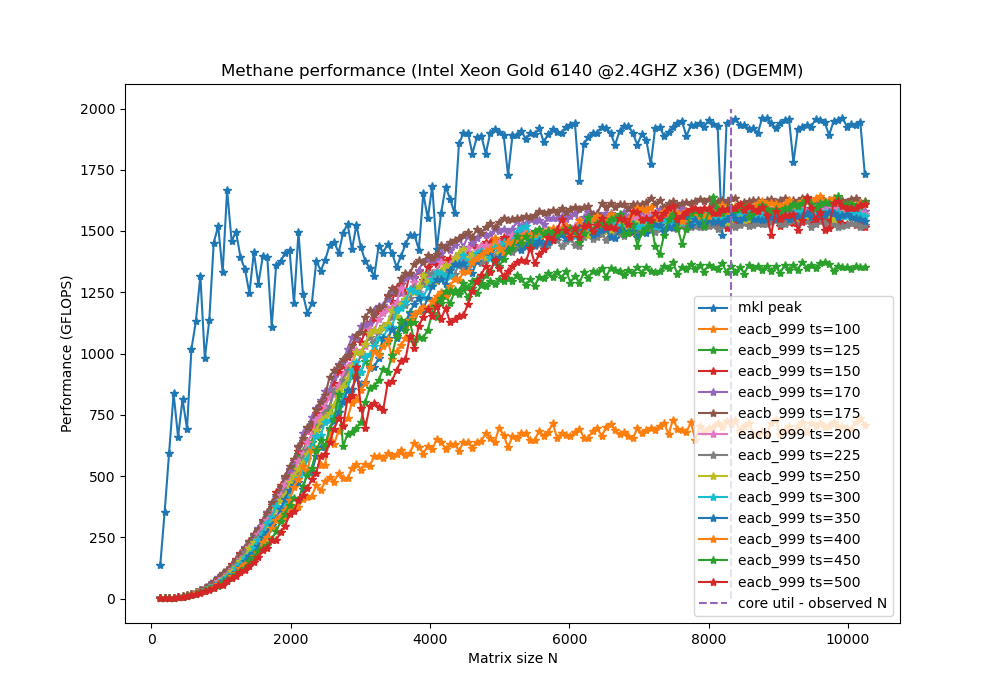

In [34]:
dgemm_methane_peak_stable = pd.read_csv("2022-06-14_36_core_peak_test.csv")
plt.ioff()
tilesizes = [100, 125, 150, 170, 175, 200, 225, 250, 300, 350, 400, 450, 500]
dgemm_methane_eacb_999 = {}

plt.figure(figsize = [10,7])
for tilesize in tilesizes:
    if tilesize in [450, 500]:
        date = "2022-06-21"
    else:
        date = "2022-06-14"
    dgemm_methane_eacb_999[tilesize] = pd.read_csv("%s_eacb999_ts%d_rectangle.csv" % (date,tilesize))

plt.plot(dgemm_methane_peak_stable["N"],    dgemm_methane_peak_stable["GFLOPS"],    "*-", label = "mkl peak")
for tilesize in tilesizes:
    plt.plot(dgemm_methane_eacb_999[tilesize]["N"],
             dgemm_methane_eacb_999[tilesize]["GFLOPS"],
             "*-", label = "eacb_999 ts=%d" % tilesize)
plt.plot([8320,8320], [0,2000], "--", label="core util - observed N")

plt.title("Methane performance (Intel Xeon Gold 6140 @2.4GHZ x36) (DGEMM)")
plt.legend()
plt.xlabel("Matrix size N")
plt.ylabel("Performance (GFLOPS)")
fname = '2022-06-14_methane_trace_performance_investigation'
plt.savefig(fname + '.svg')
plt.savefig(fname + '.pdf')
plt.savefig(fname + '.png')
display.Image(fname+'.png')

In [35]:
dgemm_mkl_peak = max(dgemm_methane_peak_stable["GFLOPS"])
tilesizemax = []
for tilesize in tilesizes:
    tilesizemax.append(max(dgemm_methane_eacb_999[tilesize]["GFLOPS"]))
dgemm_dplasma_peak = max(tilesizemax)
peak_utilization = dgemm_dplasma_peak/dgemm_mkl_peak
print("We do about %f%s as well as mkl" % (peak_utilization*100, "%"))

We do about 83.837644% as well as mkl


## Trace visualization

In [6]:
trace_potrf     = pd.HDFStore("2022-06-15_mid_dpotrf.prof.h5")
trace_omritest  = pd.HDFStore("dpotrf_tlr.2.90000.3600.2x2.mvapich2.13358284.h5")

In [7]:
# trace_omritest.event_types

In [8]:
trace_omritest.events.columns

Index(['id', 'type', 'info', 'dc_key', 'taskpool_id', 'dc_dataid', 'begin',
       'k', 'stream_id', 'size', 'trc', 'm', 'rd_fid', 'node_id', 'n', 'tcid',
       'flags', 'end', 'sde:::PARSEC::SCHEDULER::PENDING_TASKS_start',
       'sde:::PARSEC::SCHEDULER::PENDING_TASKS', 'src', 'dst', 'tpid', 'dep',
       'tid'],
      dtype='object')

### Analyzing with hwloc-ls

In [9]:
"""
myfile = open("test_trace_info.txt", "w")
myfile.write(trace_potrf.information["HWLOC-XML"])
myfile.close()
"""
# With more time, I might be able to integrate NUMA node knowledge with stream_id

'\nmyfile = open("test_trace_info.txt", "w")\nmyfile.write(trace_potrf.information["HWLOC-XML"])\nmyfile.close()\n'

### POTRF

In [10]:
panimate.animate_trace(trace_potrf,
                     "potrf",
                     which_animate = "progress",
                     title = "potrf trace testing",
                     num_frames = 60,
                     fill = "relative",
                     fps = 10,
                     N = 5400,
                     M = 5400,
                     K = 5400,
                     tilesize = 180)

Beginning animation of data 'potrf trace testing' method 'progress'
After observing your trace, I am guessing it is from the ptg interface
I think this trace is for a task that was running on dplasma
found task type potrf_dgemm (#17)
found task type potrf_dsyrk (#18)
found task type potrf_dtrsm (#19)
found task type potrf_dpotrf (#20)
checking work tasks uniqueness
checking index and preparing work tasks for  17
time for array prep:   0.14450716972351074
checking index and preparing work tasks for  18
time for array prep:   0.14362359046936035
checking index and preparing work tasks for  19
time for array prep:   0.13649392127990723
checking index and preparing work tasks for  20
time for array prep:   0.1447889804840088
done checking uniqueness. Building order dataframe
process runtime per frame: 0.001150 seconds
estimated execution time (assuming a lightweight commercial processor): 10.940307 seconds


Data titled 'potrf trace testing'
M=5400,	N=5400,	K=5400,	tilesize=180
average task execution time: 0.331854
task execution time standard deviation: 0.494324
utilization: 23.851412 over 36 cores (0.662539)
execution time to generate graphs: 5.712721 seconds
execution time to preprocess data: 1.206393 seconds
execution time total: 6.919114 seconds
saved task metadata file: tasks_per_frame_(potrf trace testing).png
saved task metadata file: tasks_times_execution_order_(potrf trace testing).png
saved task metadata file: tasks_times_sorted_(potrf trace testing).png



In [11]:
panimate.animate_trace(trace_potrf,
                     "potrf",
                     which_animate = "progress",
                     title = "potrf trace testing",
                     num_frames = 60,
                     fill = "absolute",
                     fps = 10,
                     N = 5400,
                     M = 5400,
                     K = 5400,
                     tilesize = 180)

Beginning animation of data 'potrf trace testing' method 'progress'
After observing your trace, I am guessing it is from the ptg interface
I think this trace is for a task that was running on dplasma
found task type potrf_dgemm (#17)
found task type potrf_dsyrk (#18)
found task type potrf_dtrsm (#19)
found task type potrf_dpotrf (#20)
checking work tasks uniqueness
checking index and preparing work tasks for  17
time for array prep:   0.14256501197814941
checking index and preparing work tasks for  18
time for array prep:   0.15236282348632812
checking index and preparing work tasks for  19
time for array prep:   0.14551353454589844
checking index and preparing work tasks for  20
time for array prep:   0.1792006492614746
done checking uniqueness. Building order dataframe
process runtime per frame: 0.001150 seconds
estimated execution time (assuming a lightweight commercial processor): 10.940307 seconds


Data titled 'potrf trace testing'
M=5400,	N=5400,	K=5400,	tilesize=180
average task execution time: 0.331854
task execution time standard deviation: 0.494324
utilization: 23.851412 over 36 cores (0.662539)
execution time to generate graphs: 5.642226 seconds
execution time to preprocess data: 1.363988 seconds
execution time total: 7.006214 seconds
saved task metadata file: tasks_per_frame_(potrf trace testing).png
saved task metadata file: tasks_times_execution_order_(potrf trace testing).png
saved task metadata file: tasks_times_sorted_(potrf trace testing).png



In [12]:
panimate.animate_trace(trace_omritest,
                     "potrf",
                     which_animate = "progress",
                     title = "potrf tiled trace testing",
                     num_frames = 50,
                     fill = "absolute",
                     fps = 14,
                     N = 90000,
                     M = 90000,
                     K = 90000,
                     tilesize = 300,
                     bigtilesize = 3600)

Beginning animation of data 'potrf tiled trace testing' method 'progress'
After observing your trace, I am guessing it is from the ptg interface
I think this trace is for a task that was running on hicma
found task type hicma_dpotrf_l_3flow::potrf_dgemm (#23)
found task type hicma_dpotrf_l_3flow::potrf_dsyrk (#24)
found task type hicma_dpotrf_l_3flow::potrf_dtrsm (#25)
found task type hicma_dpotrf_l_3flow::potrf_dpotrf (#26)
found task type dpotrf_l::potrf_dgemm (#30)
found task type dpotrf_l::potrf_dsyrk (#31)
found task type dpotrf_l::potrf_dtrsm (#32)
found task type dpotrf_l::potrf_dpotrf (#33)
checking work tasks uniqueness
checking index and preparing work tasks for  23
time for array prep:   0.9106075763702393
checking index and preparing work tasks for  24
time for array prep:   0.8901233673095703
checking index and preparing work tasks for  25
time for array prep:   0.9014797210693359
checking index and preparing work tasks for  26
time for array prep:   0.9041481018066406
che

Data titled 'potrf tiled trace testing'
M=90000,	N=90000,	K=90000,	tilesize=300
average task execution time: 6.248432
task execution time standard deviation: 10.369343
utilization: 23.322200 over 127 cores (0.183639)
execution time to generate graphs: 69.418386 seconds
execution time to preprocess data: 10.971544 seconds
execution time total: 80.389929 seconds
saved task metadata file: tasks_per_frame_(potrf tiled trace testing).png
saved task metadata file: tasks_times_execution_order_(potrf tiled trace testing).png
saved task metadata file: tasks_times_sorted_(potrf tiled trace testing).png
error: expected 4545100 tasks but I only observed 12025 in the trace



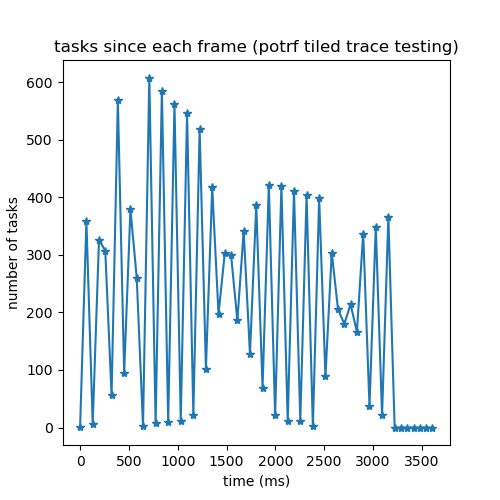

In [13]:
display.Image("tasks_per_frame_(potrf tiled trace testing).png")

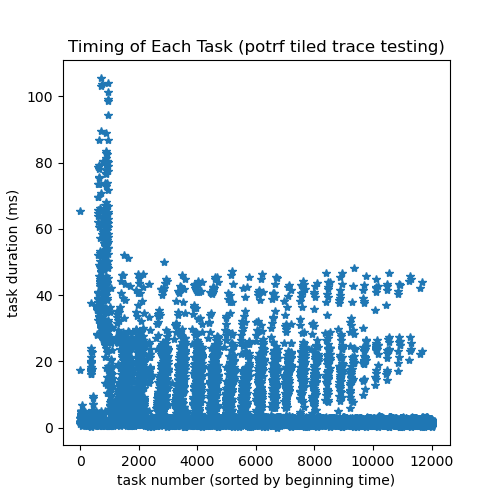

In [14]:
display.Image("tasks_times_execution_order_(potrf tiled trace testing).png")

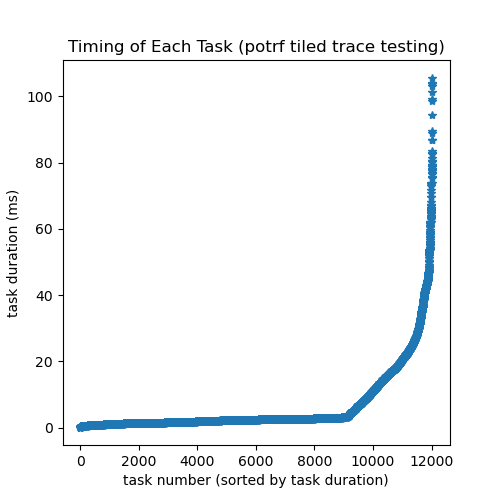

In [15]:
display.Image("tasks_times_sorted_(potrf tiled trace testing).png")

## Feedback
- go through hwloc-ls during meeting
    - spent good amount of time on this
    - seems to ignore if ht is not 2
    - mkl places work on seemingly arbitrary hyperthreads, often preferring the second hyperthread.
- `-N 10000 -t 400 -c 36 -- --ht 2`
    - N
    - tilesize
    - cores
    - `--` to parsec or not
    - hyperthreading
- Note: runtime_num_cores is a parameter that could be used in ~/.parsec/mca-params.conf
- what about 1 core: 99 GFLOPS DPLASMA, 101 GFLOPS MKL. Close.
    - `MKL_NUM_THREADS=x` <command>
- for next week: make a graph of core utilization as problem size increases
- for next week: do tilesize investigation of ptg as well (in addition to dtd)
    - to show that core swapping isn't a big deal
- ip scheduler doesn't actually pop from the back - my tool caught its first bug!
- George suggestion: try to use google kolab

- By the end of the meeting, patch applied to ip scheduler and graph re-generated